In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision as torchv
import numpy as np
import mymodels
import mycoco_small as mycoco
import torchvision.transforms as transforms
import torch.utils.data as data
from tensorboardX import SummaryWriter
import torchvision.utils as vutils
import os
import pdb
from models.model_AE_128FC import DAE
#from models.model_AE_VGG16 import AE_VGG16

from random import randint
os.environ["CUDA_VISIBLE_DEVICES"] = "4,5,6"

import matplotlib.pyplot as plt
%matplotlib inline

from torchvision import datasets, transforms
from torch.autograd import Variable
from torchvision.utils import save_image

In [2]:
print("Torch Version: {}".format(torch.__version__))
print("Cuda Available: {} \t device Count: {}".format(torch.cuda.is_available(), torch.cuda.device_count()))

Torch Version: 1.0.1.post2
Cuda Available: True 	 device Count: 3


In [3]:
BATCH_SIZE = 8
IMAGE_SIZE = 224
cuda = torch.cuda.is_available()

In [4]:
datasets

<module 'torchvision.datasets' from '/nfs/stak/users/linzhe/miniconda3/envs/general/lib/python3.6/site-packages/torchvision/datasets/__init__.py'>

In [5]:
mycoco.CocoDetection?


Init signature:
mycoco.CocoDetection(
    root,
    annFile,
    transform=None,
    target_transform=None,
    categories=None,
    batch_size=32,
    transition=False,
)
Docstring:     
`MS Coco Detection <http://mscoco.org/dataset/#detections-challenge2016>`_ Dataset.

Args:
    root (string): Root directory where images are downloaded to.
    annFile (string): Path to json annotation file.
    transform (callable, optional): A function/transform that  takes in an PIL image
        and returns a transformed version. E.g, ``transforms.ToTensor``
    target_transform (callable, optional): A function/transform that takes in the
        target and transforms it.
File:           /nfs/eecs-fserv/share/linzhe/CS535Proj/TestExamples/AutoEncoder/mycoco_small.py
Type:           type
Subclasses:     


In [6]:
def create_dataset(name='train', batch_size=32):
    dataDir='/scratch/cluster-share/linzhe/cocoDataset/'
    dataType='%s2017'%name
    annFile='{}/annotations/instances_{}.json'.format(dataDir,dataType)
    root = '%s%s'%(dataDir, dataType)

    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                         std=[0.229, 0.224, 0.225])
    trans = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                transforms.ToTensor()])
    target_transform = transforms.Compose([transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                           transforms.ToTensor()
                                           ]) # normalize to be in [-1, 1]
    coco = mycoco.CocoDetection(root, annFile, transform=trans, target_transform=target_transform, categories=['apple', 'orange', 'donut'],transition = True)
    cocoloader = data.DataLoader(coco, batch_size, num_workers=4, shuffle=True)
    
    return cocoloader, coco

In [7]:
cocoloader, cocoDataset = create_dataset(name='train', batch_size=BATCH_SIZE)
len(cocoDataset)

loading annotations into memory...
Done (t=15.54s)
creating index...
index created!


865

In [8]:
# check that there exist 10 different classes
np.unique(cocoDataset.categories)

array(['apple', 'donut', 'orange'], dtype='<U6')

torch.Size([8, 3, 224, 224])
(224, 224, 3)


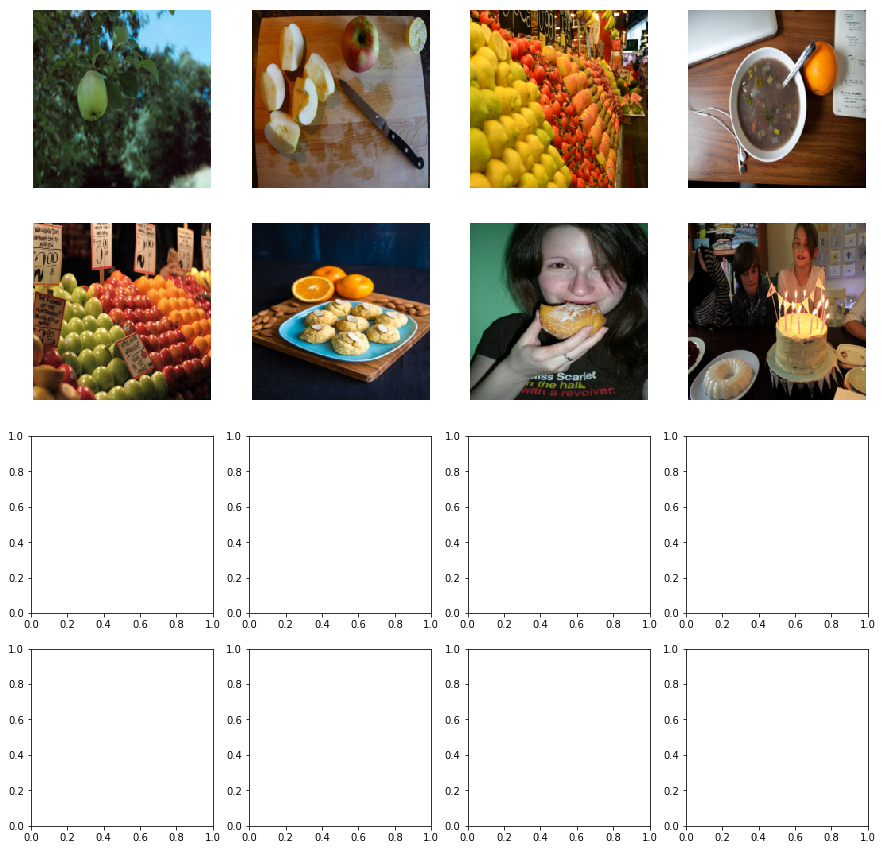

In [9]:
for im, mask, obj, _, _ in cocoloader:
    print(im.shape)
    print(np.swapaxes(np.swapaxes(im[0].numpy(),0,1),1,2).shape)
    break
    


f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
i = 0
j = 0
for im, mask, obj, _, _ in  cocoloader:
#     print(im.shape)
    for image in im:
#         print(image.numpy().T.shape)
        axarr[i, j].imshow(np.swapaxes(np.swapaxes(image.numpy(),0,1),1,2))
        axarr[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break

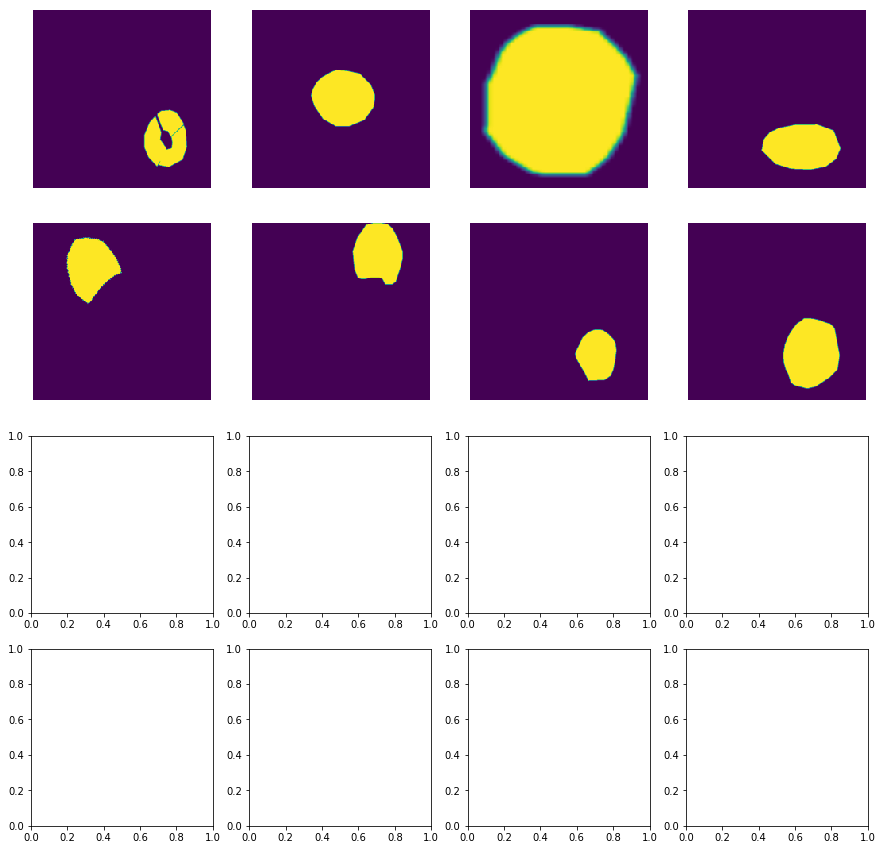

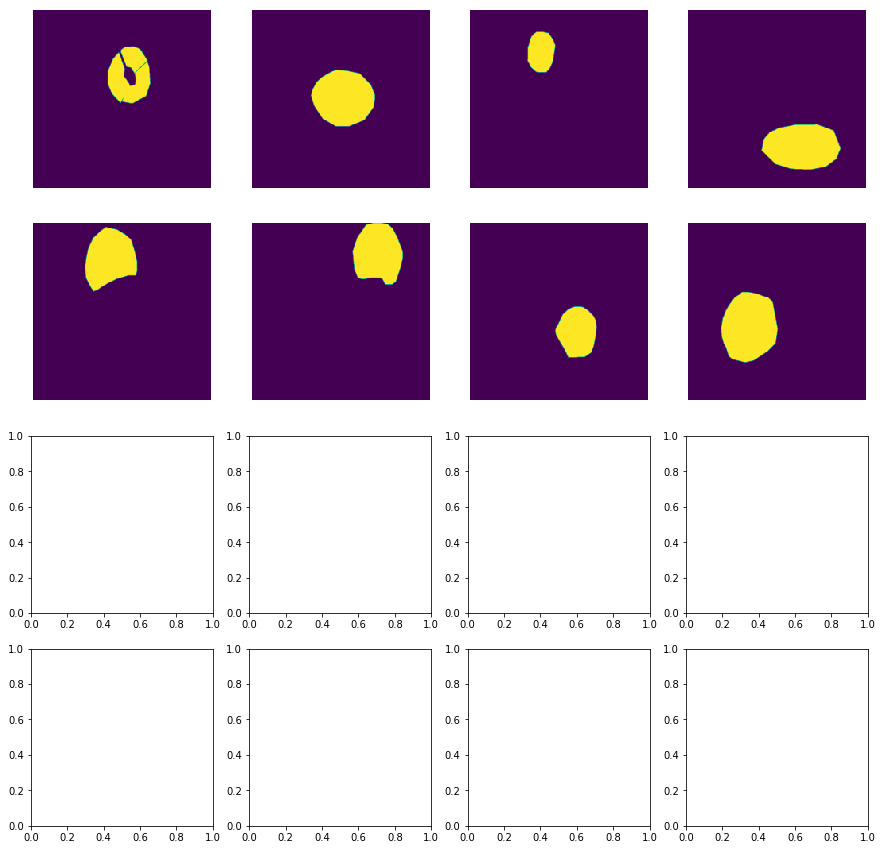

In [10]:

f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
f2, axarr2 = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f2.subplots_adjust()
i = 0
j = 0
'''
mask_transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                       transforms.ToTensor()
                                       ])
'''

for im, masks, obj, mask_trans, obj_trans in  cocoloader:
    
    for mask, mask_tran in zip(masks, mask_trans):

        axarr[i, j].imshow(mask_tran.numpy()[0])
        axarr[i, j].axis('off')
        
        axarr2[i, j].imshow(mask.numpy()[0])
        axarr2[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break
    

In [11]:

# print(np.where(np.array([0,1,1,0,1,0, 1]))[0][[0, -1]])

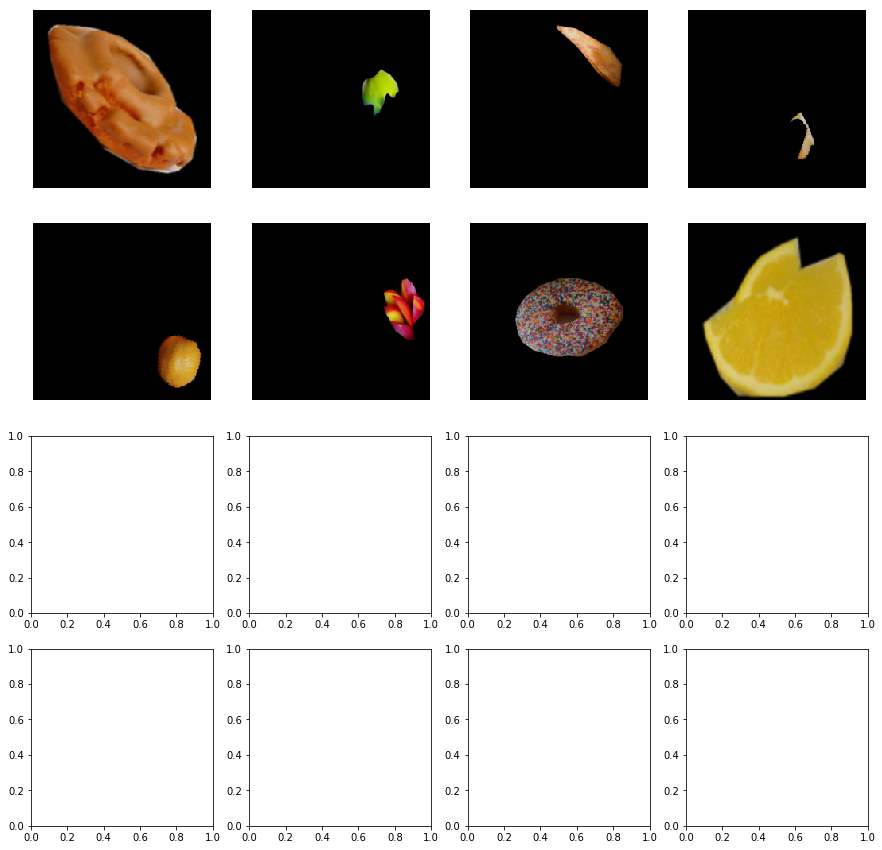

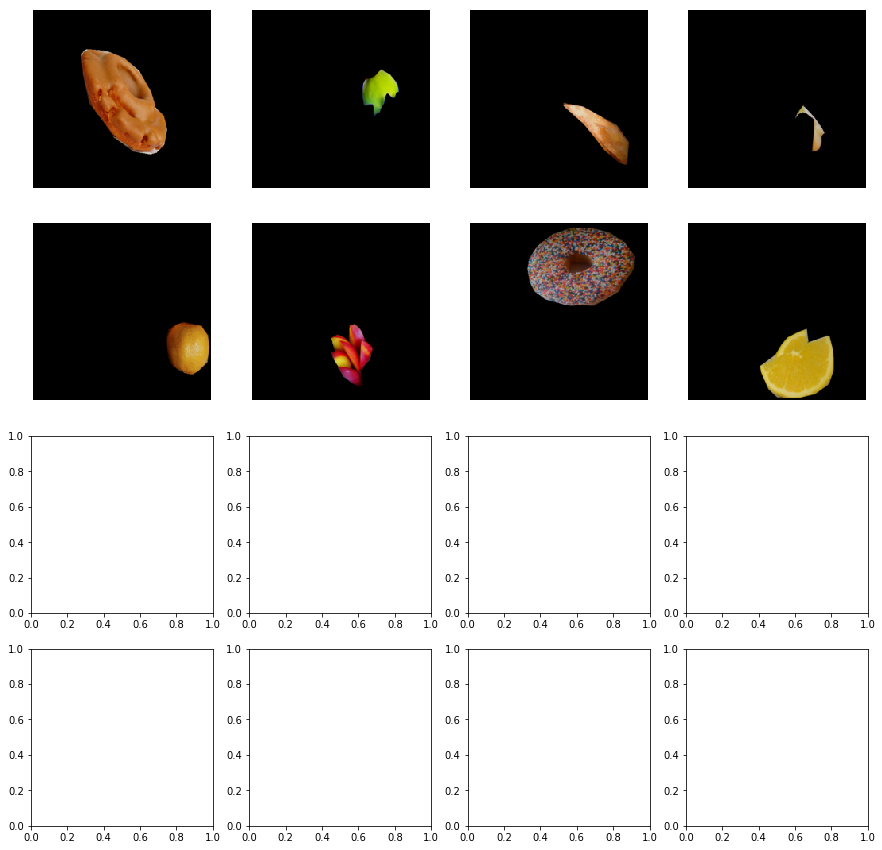

In [12]:


f, axarr = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
f2, axarr2 = plt.subplots(4, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size
f.subplots_adjust()
f2.subplots_adjust()
i = 0
j = 0

    
obj_transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
                                       transforms.ToTensor()
                                       ])

for im, masks, objs, mask_trans, obj_trans in  cocoloader:
    
    for obj, obj_tran in zip(objs, obj_trans):
        
        axarr[i, j].imshow(np.swapaxes(np.swapaxes(obj_tran.numpy(),0,1),1,2))
        axarr[i, j].axis('off')
        
        axarr2[i, j].imshow(np.swapaxes(np.swapaxes(obj.numpy(),0,1),1,2))
        axarr2[i, j].axis('off')
        j+=1
        if(j%4==0):
            i+=1
        j=j%4
        
        if(i%4==0 and i>0):
            break
    break
    

In [13]:

data_loader = cocoloader
# pin_memory if you're on GPU

In [14]:
from torch import nn

In [15]:
n_batches = int(np.ceil(len(cocoDataset)/ BATCH_SIZE)) # 60000 / 100

In [16]:
n_batches

109

In [17]:
import time


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


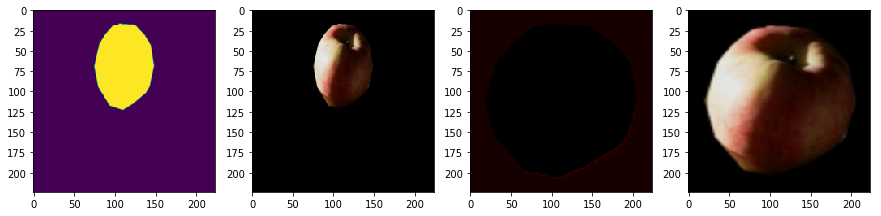

Epoch [0/200000], Step[109/109], d_loss: 15.8412, g_loss: 0.0018, Duration: 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


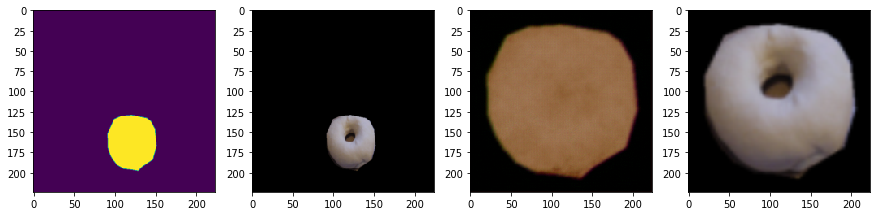

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


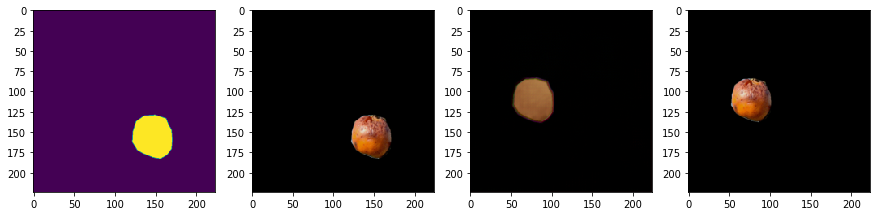

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


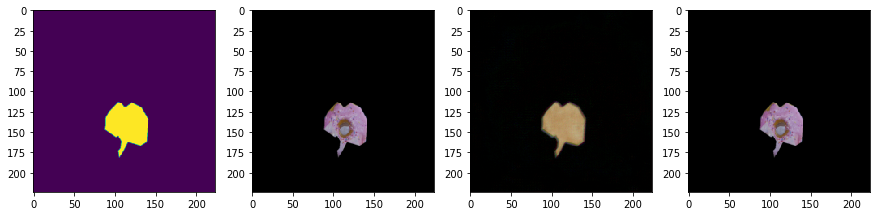

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


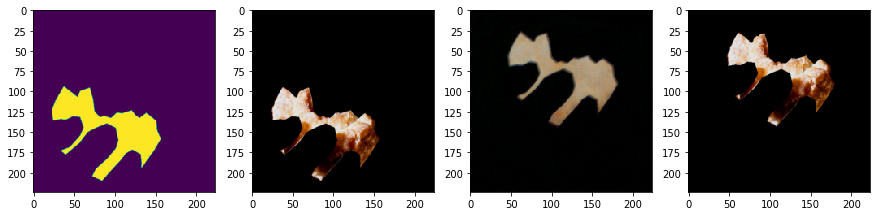

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


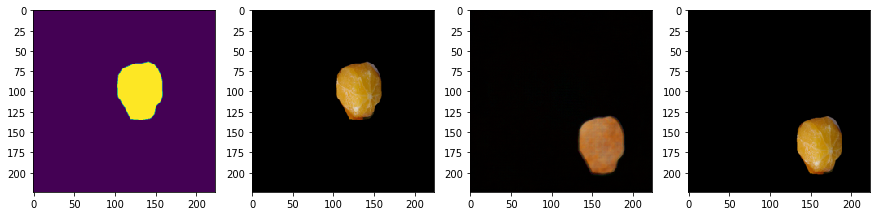

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


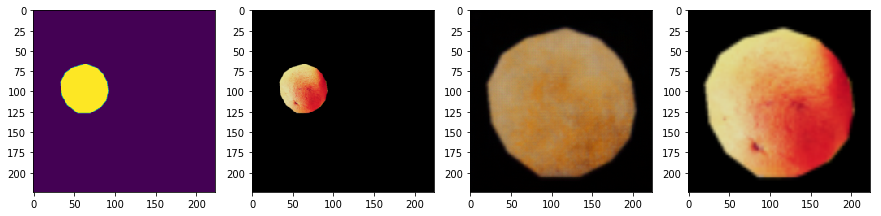

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


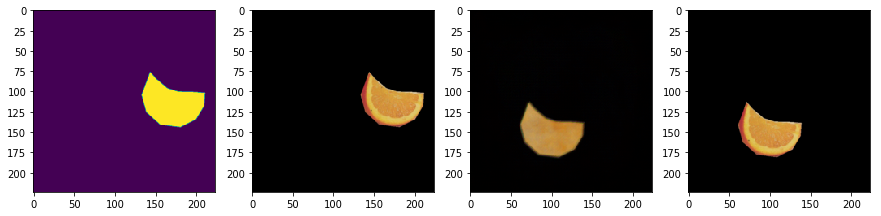

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


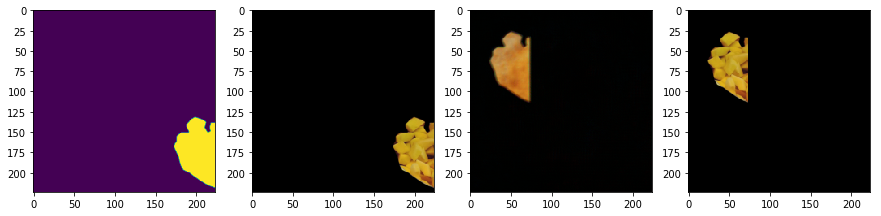

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


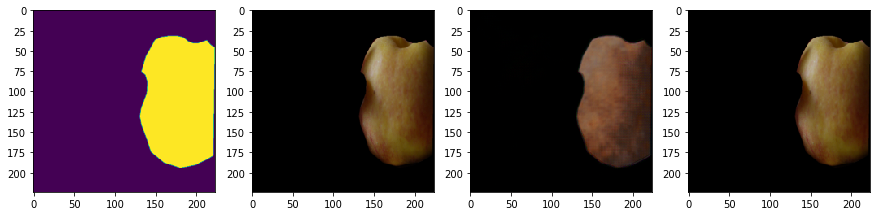

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


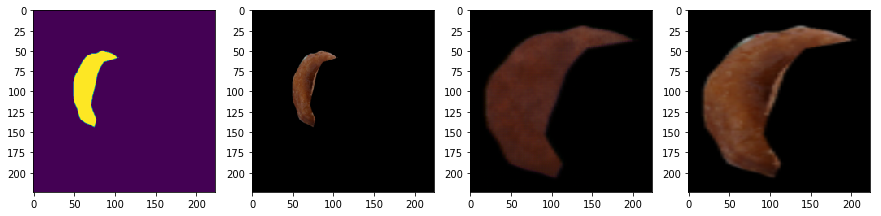

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


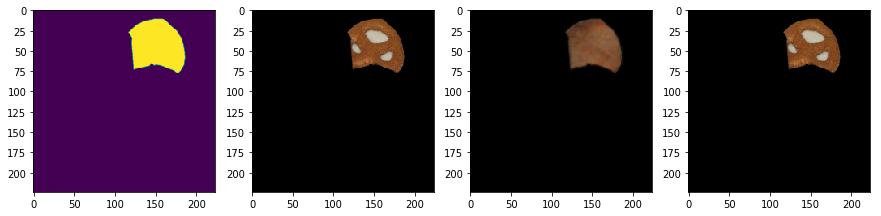

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


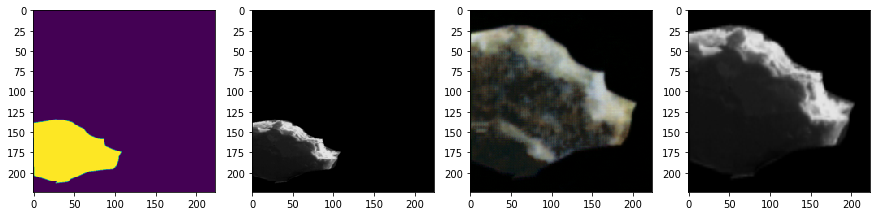

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


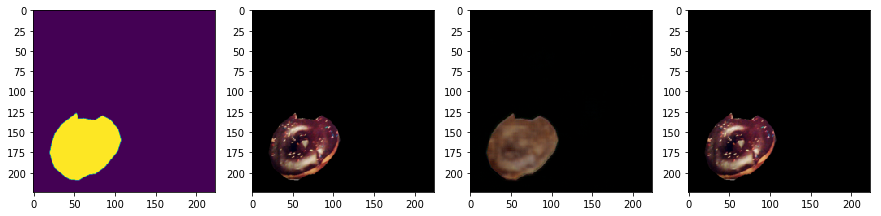

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


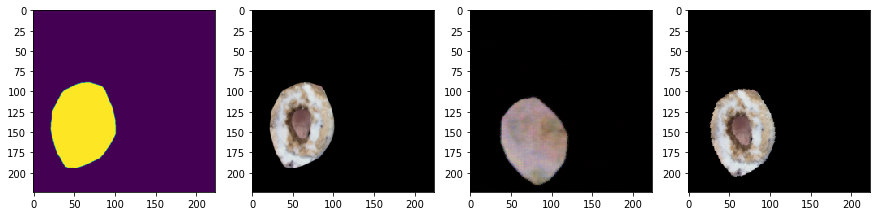

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


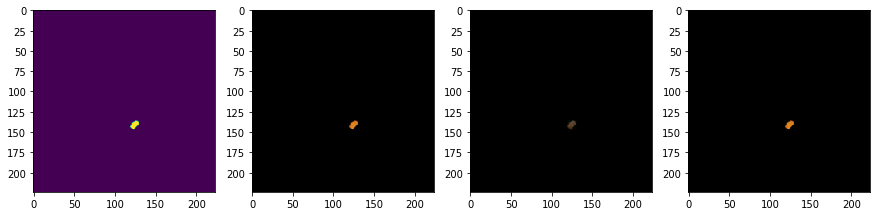

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


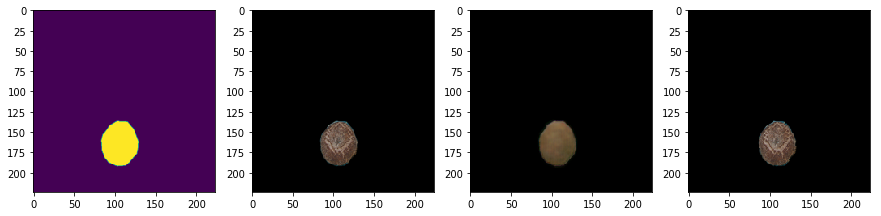

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


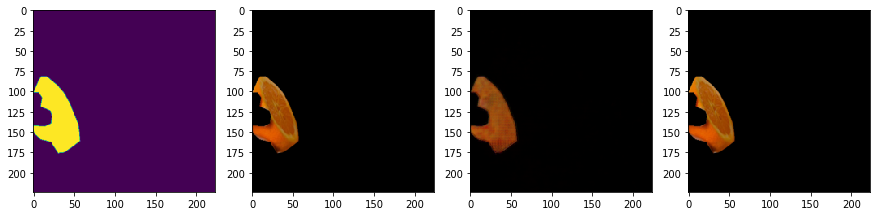

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


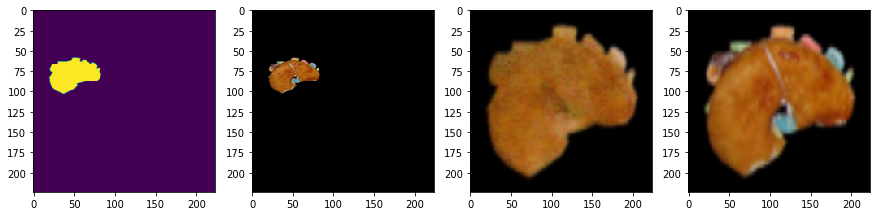

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


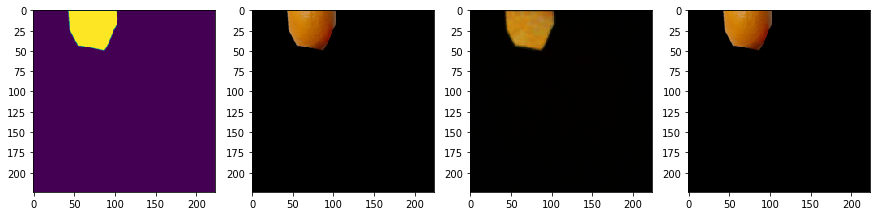

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


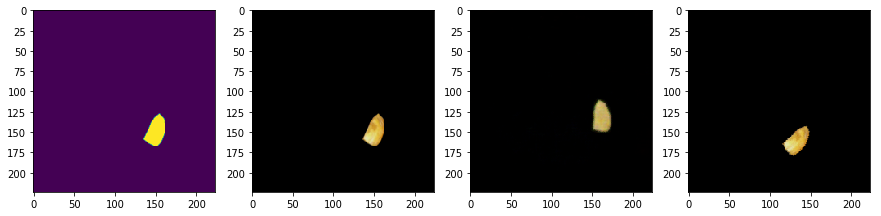

Epoch [100/200000], Step[109/109], d_loss: 1654.2575, g_loss: 0.0006, Duration: 0.00, Mean D(G(z)): 0.00


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


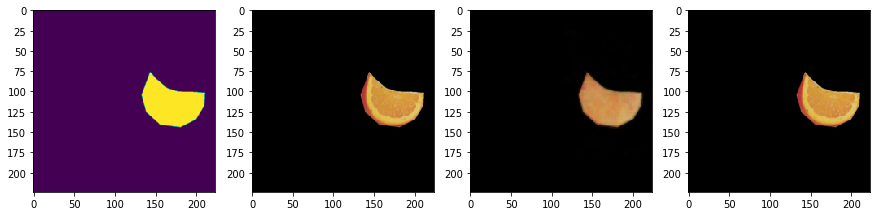

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


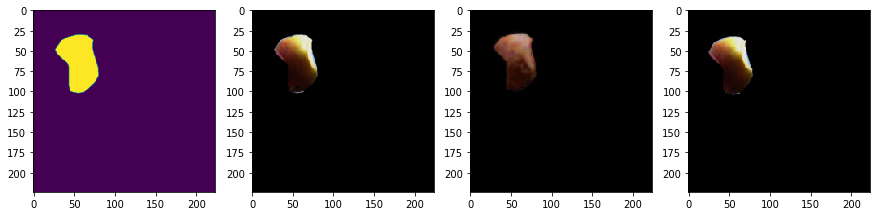

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


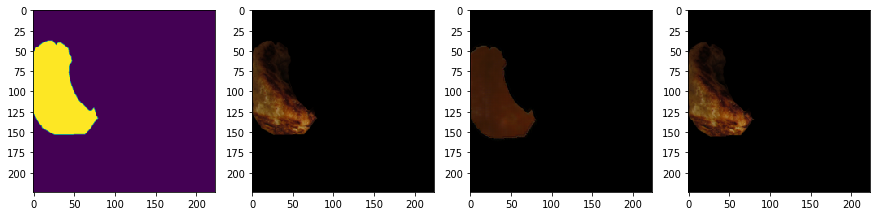

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


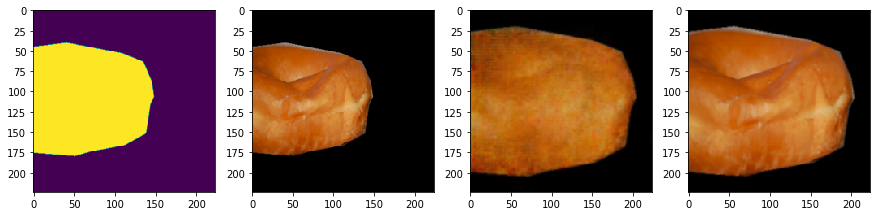

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


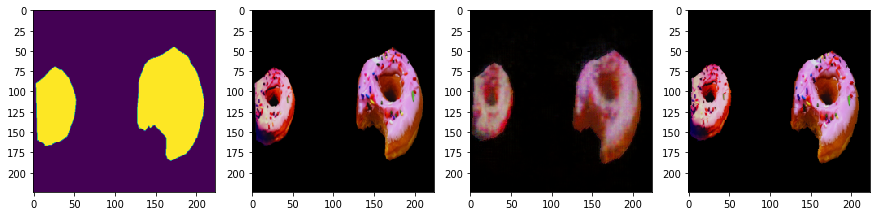

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


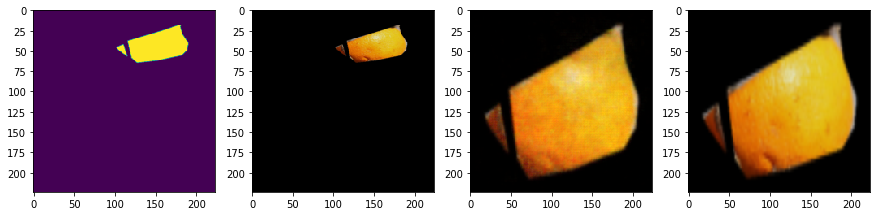

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


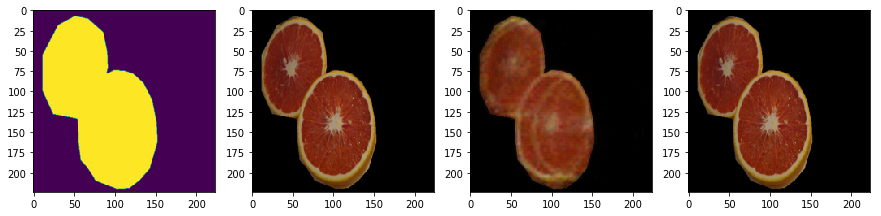

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


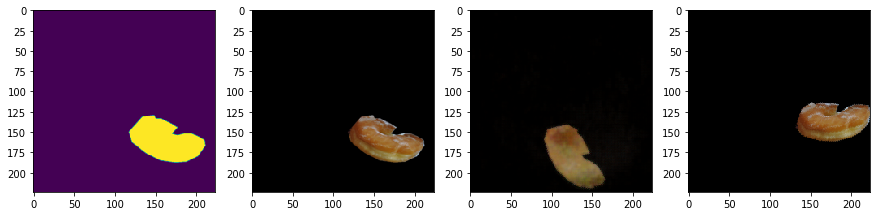

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


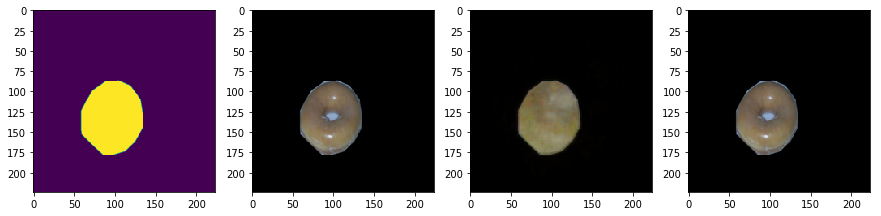

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


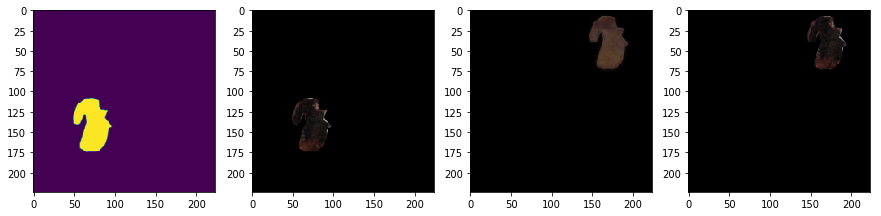

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


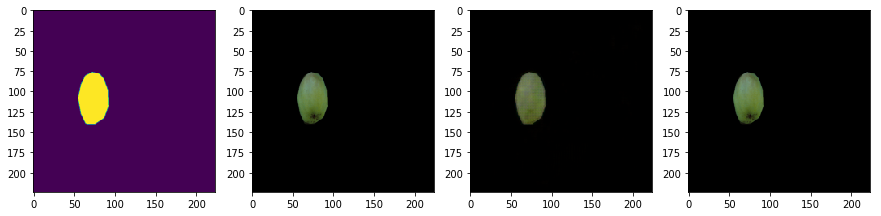

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


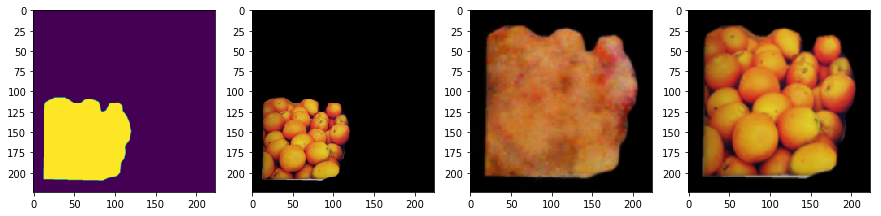

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


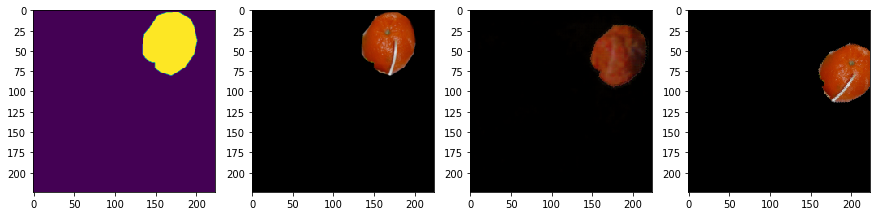

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


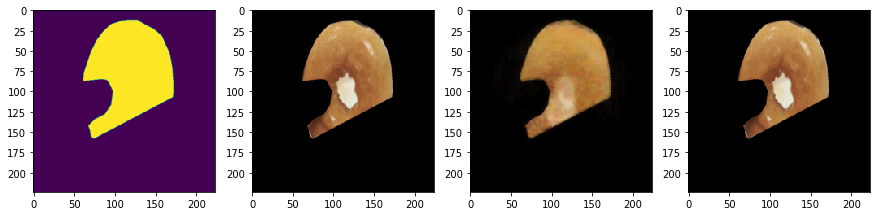

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


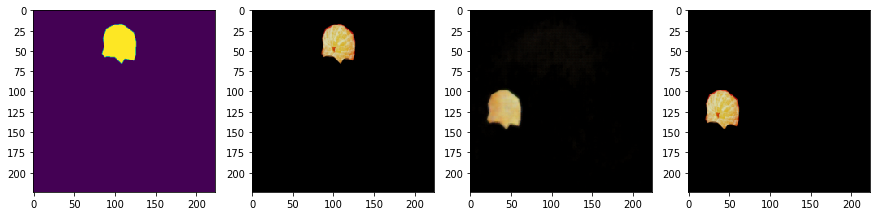

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


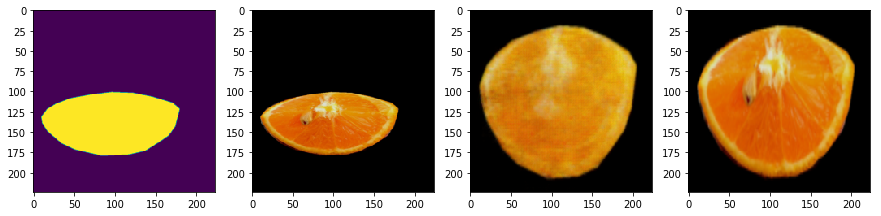

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


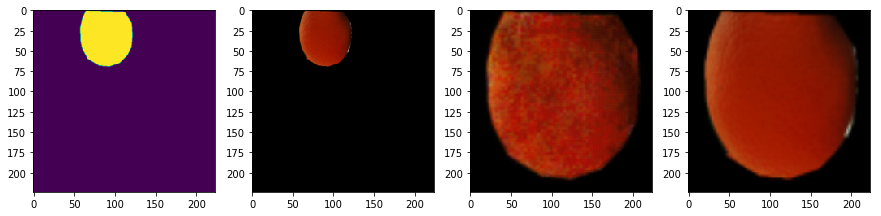

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


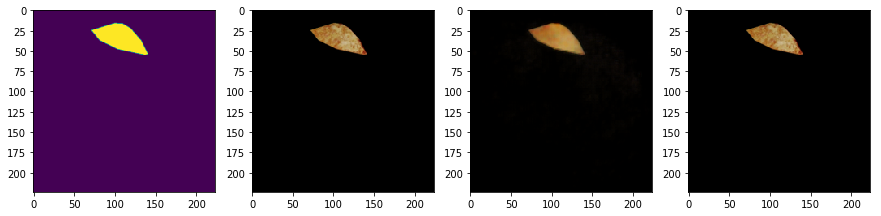

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


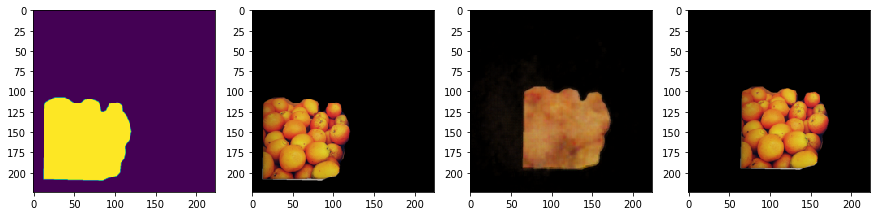

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


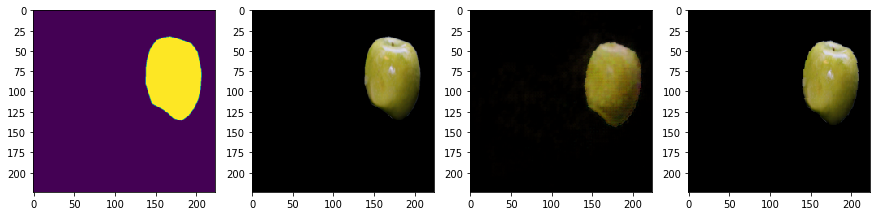

Epoch [200/200000], Step[109/109], d_loss: 1654.9997, g_loss: 0.0013, Duration: 0.00, Mean D(G(z)): 0.00


In [ ]:
dae = DAE(IMAGE_SIZE)
# dae.load_state_dict(torch.load('./weights_mask_trans/dae-500.pkl'))
# from models.model_AE_VGG16 import AE_VGG16
# ae_vgg16 = AE_VGG16(IMAGE_SIZE)
# model = ae_vgg16
model = dae

# model.load_state_dict(torch.load('./archive/masked_AE-2019-03-06 01:12:41/weights_mask_trans/last_weight.pkl'))
if cuda:
    model.cuda()
    
model = nn.DataParallel(model)    
    
num_epochs = 200000
model.batch_size = BATCH_SIZE
learning_rate = 1e-3
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
'''
f_result = open('./weights_mask_trans/train_loss.txt', 'w')
f_result.close()
'''
time_Start = time.time()
for epoch in range(num_epochs + 1):
    f_result = open('./weights_mask_trans/train_loss.txt', 'a')
    total_loss = 0
    epoch_start = True # quick hack
    
    
    
    for I, (images, masks, objs, mask_trans, objs_trans) in enumerate(cocoloader):
        #target_imgs = np.zeros_like(images)
        #target_masks = np.zeros_like(masks)
        
        #images = np.multiply(images,masks)
        
        if cuda:
            images = Variable(images).cuda()
            masks = Variable(masks).cuda()
            objs = Variable(objs).cuda()
            mask_trans = Variable(mask_trans).cuda()
            objs_trans = Variable(objs_trans).cuda()
        else:
            images = Variable(images)
            masks = Variable(masks)
            objs = Variable(objs)
            mask_trans = Variable(mask_trans)
            objs_trans = Variable(objs_trans)
            
        optimizer.zero_grad()
        z, x_hat = model(objs, mask_trans)
        #print(x.shape, x_hat.shape)
        loss = criterion(x_hat, objs_trans)
        
        #quick hack 
        if(epoch_start and epoch%5 == 0):
            f, axarr = plt.subplots(1, 4, figsize=(15, 15)) # Grid size of 10X10 and a fig size

            axarr[0].imshow(masks[0][0].data.cpu().numpy())
            axarr[1].imshow(np.swapaxes(np.swapaxes(objs[0].data.cpu().numpy(),0,1),1,2))
            axarr[2].imshow(np.swapaxes(np.swapaxes(x_hat[0].data.cpu().numpy(),0,1),1,2))
            axarr[3].imshow(np.swapaxes(np.swapaxes(objs_trans[0].data.cpu().numpy(),0,1),1,2))

            plt.show()
#             pdb.set_trace()
            save_image(torch.cat((objs[0].data.view(1,3,IMAGE_SIZE,IMAGE_SIZE),
                                  x_hat[0].data.view(1,3,IMAGE_SIZE,IMAGE_SIZE),
                                  objs_trans[0].data.view(1,3,IMAGE_SIZE,IMAGE_SIZE)), dim = 0)
                                   , './data_mask_trans/fake_inside-%0.3d.png' %(epoch + 1))
            
            epoch_start = False

        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        if (I + 1) % n_batches == 0 and epoch % 100 == 0:
            print('Epoch [%d/%d], Step[%d/%d], d_loss: %.4f, '
                  'g_loss: %.4f, Duration: %.2f, Mean D(G(z)): %.2f' 
                  %(epoch,
                    num_epochs,
                    I + 1,
                    n_batches,
                    time.time() - time_Start,
                    loss.data,
                    0,
                    0)
            )
            time_Start = time.time()
#         print()

    #Save the image
    if (epoch + 1) == 1:
        images = images.view(images.size(0), 3, IMAGE_SIZE, IMAGE_SIZE) # reshape
        save_image(images.data, './data_mask_trans/real_images.png')
        
    fake_images = x_hat
    
    
    if(epoch%10 == 0):
        save_image(fake_images.data, './data_mask_trans/fake_images-%0.3d.png' %(epoch + 1))
    #print(total_loss)
    
    f_result.write("Epoch: {}, train_loss: {}\n".format(epoch + 1, str(total_loss)))
    f_result.close()
    
    # Save the trained parameters 
    #if (epoch + 1) % 500 == 0:
    torch.save(model.state_dict(), './weights_mask_trans/last_weight.pkl')
    
#     time_Start = time.time()
    
#     torch.save(D.state_dict(), './weights/discriminator-%0.3d.pkl' %(epoch + 1))
        